# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Необходимо разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Цель исследования** — ответить на четыре вопроса по предостваленной выборке данных:
    
1. Существует ли зависимость между наличием детей у заемщиков и возвратом ими кредита в срок?
2. Существует ли зависимость между между семейным положением и возвратом кредита в срок?
3. Существует ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?  

**Оглавление**
    
1. [Открытие данных](#open)
    
    
2. [Предобработка данных](#preproc)
    * [Обработка пропусков](#blanks)
    * [Замена типа данных](#types)
    * [Обработка дубликатов](#dubl)
    * [Лемматизация](#lemm)
    * [Категоризация данных](#categ)
    
    
3. [Ответы на вопросы исследования](#answer)
    * [Зависимость между наличием детей и возвратом кредита в срок](#ans1)
    * [Зависимость между семейным положением и возвратом кредита в срок](#ans2)
    * [Зависимость между уровнем дохода и возвратом кредита в срок](#ans3)
    * [Влияние разных целей кредита на его возврат в срок](#ans4)
    
    
4. [Общий вывод](#summary)

<a id="open"></a>
## Открытие данных


In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pymystem3 import Mystem
m = Mystem() 


In [2]:
df = pd.read_csv ('/datasets/data.csv')
df.info()
display(df.head(5))
df.tail(5)
df.sample()
df.sample(n = 5,random_state = 7)
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


**Вывод**

Данные о платежеспособности клиентов вызывают вопросы.

* В поле days_employed (общий трудовой стаж в днях) дробные числа, да еще и встречаются отрицательные.
* В категориальной характеристике образования (education) - точно есть неявные дубликаты связанные с регистром.
* Поле total_income имеет чрезмерную точность для рублевого дохода.
* В полях days_employed и total_income есть пропуски.

Названия колонок выглядят нормально. Типы полей на первый взгляд соответствуют логике данных (кроме поля days_employed и вероятно, total_income).

Общее количество строк в таблице: 21525. Этого должно хватить для целей исследования, но требуется предобработка данных.

<a id="preproc"></a>
## Предобработка данных

<a id="blanks"></a>
### Обработка пропусков

Посмотрим на строки с пропущенными days_employed и посчитаем их. Затем воспользуемся медианным методом (предварительно избавившись от отрицательных чисел в колонке), чтобы заполнить пропуски.

In [3]:
df[df['days_employed'].isna()].head(5) # Пропуски, это NaN

len(df[df['days_employed'].isna()]) #Пропущено 2174 значения, около 1% от всего датафрейма, лучше их заполнить.

#Избавимся от отрицательных чисел
df['days_employed'] = df['days_employed'].abs()
days_employed_med = df['days_employed'].median()
print('Медианное значение стажа:',days_employed_med, end='\n\n') 

#Заменяем пропуски на days_employed_med
df['days_employed'] = df['days_employed'].fillna(days_employed_med)

#Проверим на строки с пропущенными days_employed
df.info() #Код сработал

Медианное значение стажа: 2194.220566878695

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Поступим аналогичным образом с полем total_income

In [4]:
df[df['total_income'].isna()].head(5) # Пропуски, это NaN

#total_income - количественная характеристика, заменим в ней пропуски на медианное значение поля.
total_income_med = df['total_income'].median()
print('Медианное значение дохода:',total_income_med, end='\n\n') 
#Заменяем пропуски на total_income_med
df['total_income'] = df['total_income'].fillna(total_income_med)

#Проверим на строки с пропущенными total_income
df.info() #Код сработал, явных пропусков в датафрэйме больше нет

Медианное значение дохода: 145017.93753253992

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Заодно проверим другие поля важные для исследования:



In [5]:

df['children'].value_counts() #-1 это точно ошибка, заменим ее на 1
df['children'] = df['children'].replace(-1, 1)
df['debt'].value_counts() # тут все в порядке

0    19784
1     1741
Name: debt, dtype: int64

**Вывод**

* Были обнаружены пропуски в полях days_employed и total_income, в обоих случаях это NaN.
* Причинами ппропусков может быть намеренное незаполнение этих данных заемщиками, однако странно если бы таким людям дали кредит. Учитывая, что в данных были артефакты в виде отрицательного стажа, причина пропуска может быть и технического характера - потеря данных при копировании, записи и т.п.
* Пропуски в этих количественных полях были заполнены медианным методом, так как разброс по стажу и доходу значительный и среднее значение может повлиять на исход исследования.

<a id="types"></a>
### Замена типа данных

Изменим тип данных в поле days_employed и total_income на целочисленный, согласно требуемой точности этих данных для исследования.

А также уменьшим объем затрачиваемой памяти в ьаблице, оптимизировав другие типы.

In [6]:
display(df.info())
df['children'] = df['children'].astype('int8')
df['days_employed'] = df['days_employed'].astype('int32')
df['dob_years'] = df['total_income'].astype('int8')
df['education_id'] = df['education_id'].astype('int8')
df['family_status_id'] = df['family_status_id'].astype('int8')
df['debt'] = df['debt'].astype('int8')
df['total_income'] = df['total_income'].astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int8  
 1   days_employed     21525 non-null  int32 
 2   dob_years         21525 non-null  int8  
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int8  
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int8  
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int8  
 10  total_income      21525 non-null  int32 
 11  purpose           21525 non-null  object
dtypes: int32(2), int8(5), object(5)
memory usage: 1.1+ MB


Засчет изменения типов полей сэкономлено около 50% памяти.

**Вывод**

В полях стажа и дохода для целей исследования достаточна целая часть значений, поэтому мы переводим эти поля в целочисленные типы. Метод to_numeric() не подходит, так как он возвращает тип float. Поэтому был использован метод astype().

<a id="dubl"></a>
### Обработка дубликатов

In [7]:
#Проверим таблицу поля на явные полные дубликаты
df.duplicated().sum() #54 строки, избавимся от них
df = df.drop_duplicates()
#Проверим
print(df.duplicated().sum()) 

#Проверим строковые поля на неявные дубликаты
df['purpose'].value_counts() #здесь лучше обработать данные с помощью лемматизации
df['gender'].value_counts() #странное значение 'XNA', но это не похоже дубликат
df['family_status'].value_counts() #здесь все нормально
df['education'].value_counts() #здесь полно неявных дубликатов, надо поработать с регистром

#приводим образование к нижнему регистру
df['education'] = df['education'].str.lower()
#проверка
display(df['education'].value_counts())


0


среднее                14670
высшее                  5154
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

**Вывод**

Сначала были выявлены полные явные дубликаты, от них избавляемся методом drop_duplicates(). Затем с помощью value_counts() были просмотрены строковые поля на признак неявных дублей, были замечены проблемы с регистром в поле education и исправлены с помощью str.lower().

Появление разнорегистровых дубликатов возможно произошло из-за человеческого фактора при вводе данных.

<a id="lemm"></a>
### Лемматизация

In [8]:
#Получаем список уникальных значений из поля purpose
purpose_uniq = df['purpose'].unique()
#print(purpose_uniq)

#првевращаем список в строку для дальнейшей лемматизации
purpose_uniq_str =' '.join(purpose_uniq)
#print(purpose_uniq_str)

#Лемматизируем полученную строку
lemmas = m.lemmatize(purpose_uniq_str)
print(lemmas) 
print()

#подсчитаем вхождения лемм в строке
from collections import Counter
print(Counter(lemmas)) 
#Основные леммы выделены: недвижимсть, автомобиль, строительство, образование, свадьба, ремонт, жилье

['покупка', ' ', 'жилье', ' ', 'приобретение', ' ', 'автомобиль', ' ', 'дополнительный', ' ', 'образование', ' ', 'сыграть', ' ', 'свадьба', ' ', 'операция', ' ', 'с', ' ', 'жилье', ' ', 'образование', ' ', 'на', ' ', 'проведение', ' ', 'свадьба', ' ', 'покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', ' ', 'покупка', ' ', 'недвижимость', ' ', 'покупка', ' ', 'коммерческий', ' ', 'недвижимость', ' ', 'покупка', ' ', 'жилой', ' ', 'недвижимость', ' ', 'строительство', ' ', 'собственный', ' ', 'недвижимость', ' ', 'недвижимость', ' ', 'строительство', ' ', 'недвижимость', ' ', 'на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', ' ', 'на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', ' ', 'операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', ' ', 'строительство', ' ', 'жилой', ' ', 'недвижимость', ' ', 'жилье', ' ', 'операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', ' ', 'автомобиль', ' ', 'заниматься', ' ', 'образование', ' ', 'сделка', ' ', 'с', ' ', 'подержать

In [9]:
#Напишем функцию, которая будет лематизировать строки столбца purpose и проверять, какая из категорий там обнаруживается,
#чтобы затем категоризировать данные:
def lemma_func (row):
    
    purpose = row['purpose']
    
    for i in range(len(df)):
        try: 

            if 'ремонт' in  m.lemmatize(purpose):
                return 'Ремонт'
            elif  'недвижимсть' in  m.lemmatize(purpose):
                return 'Недвижимсть'
            elif 'жилье' in  m.lemmatize(purpose):
                return 'Недвижимсть'
            elif 'строительство' in  m.lemmatize(purpose):
                return 'Недвижимсть'
            elif 'автомобиль' in  m.lemmatize(purpose):
                return 'Автомобиль'
            elif 'образование' in  m.lemmatize(purpose):
                return 'Образование'
            elif 'свадьба' in  m.lemmatize(purpose):
                return 'Свадьба'
            else:
                return 'Другое'
        except:
            return 'Ошибка' 
    
df['purpose_cat'] = df.apply(lemma_func, axis=1)
display(df.head(10))  

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_cat
0,1,8437,-77,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,Недвижимсть
1,1,4024,-48,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,Автомобиль
2,0,5623,-35,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,Недвижимсть
3,3,4124,108,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,Образование
4,0,340266,-104,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,Свадьба
5,0,926,19,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,Недвижимсть
6,0,2879,-115,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,Недвижимсть
7,0,152,-113,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,Образование
8,2,6929,112,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,Свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,Недвижимсть


**Вывод**

Выделены основные леммы: недвижимсть, автомобиль, строительство, образование, свадьба, ремонт, жилье. Создана функция, соотносящая цели по категориям целей исходя из выводов лемматизации. Функция применена к отдельному полю, теперь можно разбить данные на словари и основной датафрейм.

<a id="categ"></a>
### Категоризация данных

In [10]:
#Для целей исследования разделим таблицу на основной датафрейм credit_info и таблицы-справочники.
#Основной датафрэйм:
credit_info = df[['children','days_employed','days_employed','dob_years','days_employed','education_id','family_status_id','gender','income_type','debt','total_income','purpose_cat']]
credit_info

#Справочник по образованию заемщика:
education_dict = df[['education_id', 'education']]
#удалим дубликаты
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
education_dict.head(15)

#Справочник по семейному статусу заемщика:
family_status_dict = df[['family_status_id', 'family_status']]
#удалим дубликаты
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
display(family_status_dict.head(15))


,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


**Вывод**

Данные были категоризированы на основной датафрэйм и на словари по образованию и по семейному статусу. Эти словари были выбраны потому, что значения в них ограничены и немногочисленны, а в основной таблице удобнее будет работать с числами.

<a id="answer"></a>
## Ответы на вопросы исследования

<a id="ans1"></a>
### Есть ли зависимость между наличием детей и возвратом кредита в срок?

,debt
children_cat,
Малодетные,0.094211
Многодетные,0.085714
Бездетные,0.077488


,debt
children_cat,
С детьми,0.093676
Бездетные,0.077488


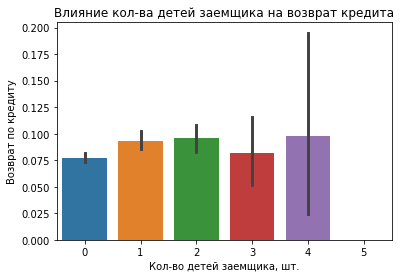

In [11]:
#Сгруппируем данные о количестве детей для удобства представления будущего результата. Используем для этого функцию.
def children_cnt_func (row):

    children = row['children']   
    for i in range(len(credit_info)):
        try: 
            if children == 0:
                return 'Бездетные'
            elif children > 0 and children < 3:
                return 'Малодетные'
            elif children > 2:
                return 'Многодетные'
        except:
            return 'Ошибка'
credit_info['children_cat'] = credit_info.apply(children_cnt_func, axis=1)
credit_info.head(10)

#Посмотрим каково среднее значение debt для разных категорий по количеству детей
data_pivot_det = credit_info.pivot_table(index=['children_cat'], values='debt', aggfunc='mean')
display(data_pivot_det.sort_values('debt', ascending = False))
#возврат кредита у мало и многодетных отличается не сильно, но положительная зависимость прослеживается. 

#Поскольку мало и многодетные не слишком различаются по debt, объединим эти категории в одну
def children_cnt_func2 (row):
    children = row['children']   
    for i in range(len(credit_info)):
        try:  
            if children == 0:
                return 'Бездетные'
            elif children > 0:
                return 'С детьми'
        except:
            return 'Ошибка'
        
credit_info['children_cat'] = credit_info.apply(children_cnt_func2, axis=1)
credit_info.head(10)      
data_pivot_det = credit_info.pivot_table(index=['children_cat'], values='debt', aggfunc='mean')
display(data_pivot_det.sort_values('debt', ascending = False))

'''
#Процент бездетных среди невыплативших кредит в срок:
bezdet_debt = credit_info[(credit_info['children'] == 0) & (credit_info['debt'] == 0)]['children'].count()
bezdet_nodebt = credit_info[(credit_info['children'] == 0) & (credit_info['debt'] == 1)]['children'].count()
total = len(credit_info['children'])
print('Процент бездетных среди невыплативших кредит в срок {:.0%}'.format(bezdet_debt/total)) 
print('Процент бездетных среди выплативших кредит в срок {:.0%}'.format(bezdet_nodebt/total)) 
#Данное сравнение некорректно, так как бездетных в выборке сильно меньше, чем людей с детьми.
'''

#Построим график зависимости между количеством детей и возвратом долга
sb.barplot(data=credit_info, x="children", y="debt")

#Обнаглеем и предположим, что 20 детей это перебор и имелось ввиду 2
credit_info['children'] = credit_info['children'].replace(20, 2)
# перестроим график
bar1 = sb.barplot(data=credit_info, x="children", y="debt")
bar1.set(title='Влияние кол-ва детей заемщика на возврат кредита', xlabel='Кол-во детей заемщика, шт.', ylabel='Возврат по кредиту')
plt.show()

**Вывод**

Некоторая зависимость между наличием детей и возвратом кредита в срок прослеживается в данной выборке и она положительная. Однако у людей с тремя детьми видно некоторое снижение платежеспособности относительно соседних категорий.

<a id="ans2"></a>
### Есть ли зависимость между семейным положением и возвратом кредита в срок?

,debt
family_status,
Не женат / не замужем,0.099096
гражданский брак,0.095238
женат / замужем,0.077716
в разводе,0.071730
вдовец / вдова,0.066667


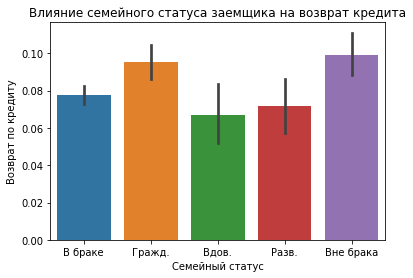

In [12]:
#вернем словарь по семейному статусу для текущего исследования
credit_info_family = credit_info.merge(family_status_dict, on='family_status_id', how='left')
credit_info_family.head(10)   

#Посмотрим каково среднее значение debt для разных категорий по семейному статусу
data_pivot_fam = credit_info_family.pivot_table(index=['family_status'], values='debt', aggfunc='mean')
display(data_pivot_fam.sort_values('debt', ascending = False))

#Построим график зависимости между семейным статусом и возвратом долга
credit_info_family['family_status'] = credit_info_family['family_status'].replace('Не женат / не замужем','Вне брака').replace('гражданский брак','Гражд.').replace('женат / замужем','В браке').replace('в разводе','Разв.').replace('вдовец / вдова','Вдов.')

bar2 = sb.barplot(data=credit_info_family, x="family_status", y="debt")
bar2.set(title='Влияние семейного статуса заемщика на возврат кредита', xlabel='Семейный статус', ylabel='Возврат по кредиту')
plt.show()

**Вывод**

Несмотря на то, что люди со статусом "Не женат / не замужем" в данной выборке чаще возвращают кредит в срок, говорить о наличии четкой зависимости здесть некорректно.
Категория "Не женат / не замужем" может совпадать со всеми категориями, кроме "женат / замужем" и рассматривать ее отдельно было бы неправильно.
Среди остальных категорий можно выделить "Гражданский брак", здесь высокий процент платежеспособности. В категориях "в разводе" и "вдовец / вдова" возвраты по кредитам ниже среднего.

<a id="ans3"></a>
### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

,debt
total_income_cat,
120-200 т.р,0.092129
<30 т.р,0.090909
70-120 т.р,0.083783
>1000 т.р.,0.080000
300-500 т.р,0.073016
200-300 т.р,0.070312
30-70 т.р,0.068182
500-1000 т.р,0.060914


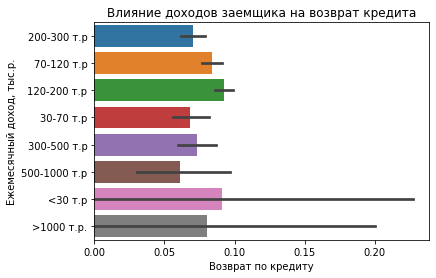

In [13]:
#Сгруппируем данные о доходе. Используем для этого функцию.
def income_func (row):

    total_income = row['total_income']   
    for i in range(len(credit_info)):
        try: 
            if total_income <= 30000:
                return '<30 т.р'
            elif total_income > 30000 and total_income <= 70000:
                return '30-70 т.р'
            elif total_income > 70000 and total_income <= 120000:
                return '70-120 т.р'
            elif total_income > 120000 and total_income <= 200000:
                return '120-200 т.р'
            elif total_income > 200000 and total_income <= 300000:
                return '200-300 т.р'
            elif total_income > 300000 and total_income <= 500000:
                return '300-500 т.р'
            elif total_income > 500000 and total_income <= 1000000:
                return '500-1000 т.р'
            elif total_income > 1000000:
                return '>1000 т.р.'
        except:
            return 'Ошибка'
        
credit_info['total_income_cat'] = credit_info.apply(income_func, axis=1)
credit_info.head(10)

#Посмотрим каково среднее значение debt для разных категорий по ежемесячному доходу
data_pivot_inc = credit_info.pivot_table(index=['total_income_cat'], values='debt', aggfunc='mean')
display(data_pivot_inc.sort_values('debt', ascending = False))

#Построим график зависимости между ежемесячным доходом и возвратом долга

bar3 = sb.barplot(data=credit_info, y="total_income_cat", x="debt")
bar3.set(title='Влияние доходов заемщика на возврат кредита', xlabel='Возврат по кредиту', ylabel='Ежемесячный доход, тыс.р.')
plt.show()



**Вывод**

Четкая зависимость между ежемесячным доходом и возвратом кредита в срок не прослеживается. В категории самого низкого дохода чаще всего кредит возвращается в срок, однако по остальным значениям происходит случайный разброс, а минимумы приходятся на совершенно разные категории 30-70 т.р и 500-1000 т.р.

<a id="ans4"></a>
### Как разные цели кредита влияют на его возврат в срок?

,debt
purpose_cat,
Автомобиль,0.095408
Образование,0.094220
Свадьба,0.081982
Другое,0.075859
Недвижимсть,0.074592
Ремонт,0.059222


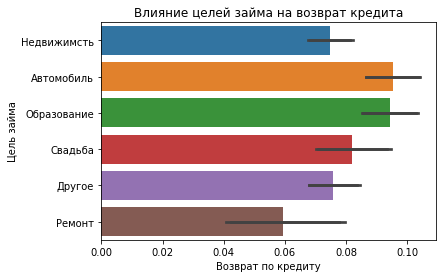

In [14]:
#Посмотрим каково среднее значение debt по разным целям кредита
data_pivot_purp = credit_info.pivot_table(index=['purpose_cat'], values='debt', aggfunc='mean')
display(data_pivot_purp.sort_values('debt', ascending = False))

#Построим график зависимости между семейным статусом и возвратом долга
sb.barplot(data=credit_info, x="debt", y="purpose_cat")

bar4 = sb.barplot(data=credit_info, y="purpose_cat", x="debt")
bar4.set(title='Влияние целей займа на возврат кредита', xlabel='Возврат по кредиту', ylabel='Цель займа')
plt.show()

**Вывод**

Судя по графику, чаще в срок возвращают кредит заемщики, которые берут его для покупки автомобиля и в целях образования. На втором месте идут свадебные цели. Заемщики, берущие кредит в целях операций с недвижимостью и для других (неопределенных в исследовании) целей занимают третье место. На последнем месте по возвратам оказались заемщики с целями по ремонту.

<a id="summary"></a>
## Общий вывод

* В данных предложенных для исследования были выявлены явные и неявные дубликаты, пропуски, артефакты в виде отрицательных чисел в полях, где их не должно быть.
* Проведена предобработка данных, пропуски в количественных характеристиках были заполнены медианным методом, явные дубликаты удалены, неявные дубликаты строковых типов устранены с помощью приведения к одному регистру.
* Данные были лемматизированы и разбиты на категории для удобства исследования и предоставлений результата.

Были получены ответы на вопросы исследования:

1.Есть ли зависимость между наличием детей и возвратом кредита в срок?<br>`Некоторая зависимость между наличием детей и возвратом кредита в срок прослеживается в данной выборке и она положительная. В среднем доля возвратов кредита в срок у заемщиков с детьми 93% , в то время как у бездетных заемщиков 77%.`

2.Есть ли зависимость между семейным положением и возвратом кредита в срок?<br>`Четкой зависимости не выявлено. Наиболее часто (99% и 95% соответственно) в срок возвращаются кредиты у заемщиков вне брака, а также в гражданском браке. Снижение возвращаемости займа наблюдается у категорий в браке и в разводе - 77% и 71% соответственно. Наиболее низкий процент возвратов в категории вдовец/вдова, всего 67%.`

3.Есть ли зависимость между уровнем дохода и возвратом кредита в срок?<br>`Четкой зависимости не выявлено. В категории самого низкого дохода (менее 30т.р. в месяц) чаще всего кредит возвращается в срок (91%), однако по остальным значениям происходит случайный разброс, а минимумы приходятся на совершенно разные категории 30-70 т.р и 500-1000 т.р. - 68% и 61% соответственно.`

4.Как разные цели кредита влияют на его возврат в срок?<br>`Чаще в срок возвращают кредит заемщики, которые берут его для покупки автомобиля (95% случаев) и в целях образования (94% случаев). На втором месте идут свадебные цели (82%). Заемщики, берущие кредит в целях операций с недвижимостью (75%) и для других (неопределенных в исследовании) целей (76%) занимают третье место. На последнем месте по возвратам оказались заемщики с целями по ремонту - всего 59% возвратов.`